In [1]:
import pandas as pd
from fastai.vision.all import *
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('age_gender.csv')
df

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 149 147 145 146 147 148 149 149 150 153 153 153 152 153 153 153 153 153 151 149 147 146 146 144 143 140 134 129 129 126 122 121 119 118 118 99 53 130 129 128 126 127 130 135 141 143 143 144 145 143 142 144 145 146 149 149 148 151 151 151 151 152 153 153 153 153 149 148 147 146 146 142 141 138 133 130 130 128 123 124 122 120 117 98 52 131 129 130 129 129 134 138 144 145 143 143 139 140 138 139 140 142 145 147 149 151 149 149 149 151 152 151 150 150 148 147 145 144 142 140 137 136 135 134 131 128 126 126 123 122 114 97 50 135 134 133 132 131 136 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199 200 199 200 196 198 192 193 188 187 186 187 188 183 182 178 177 175 174 176 174 172 165 158 153 147 142 138 131 125 120 114 110 110 111 111 104 179 70 128 171 169 171 175 182 183 187 193 197 198 196 194 189 188 185 183 184 180 182 184 178 174 173 173 173 174 174 176 171 165 160 154 149 144 139 133 129 125 119 117 113 110 112 113 108 176 71 146 169 168 171 175 177 182 185 186 187 188 191 191 186 185 181 179 178 173 174 176 169 164 168 168 169 170 171 170 165 154 148 145 141 137 134 131 130 124 121 116 112 112 112 112 109 179 77 159 172 171 171 ...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155 161 166 169 175 177 178 179 180 183 186 187 188 192 194 198 203 206 213 214 216 220 219 215 213 211 211 210 207 206 203 200 197 194 192 65 66 69 70 70 69 72 83 88 100 112 125 139 155 159 165 167 170 174 176 178 177 180 185 186 187 190 193 195 197 201 207 208 212 215 215 215 213 211 211 210 207 204 201 200 197 194 192 61 63 69 71 70 70 72 81 87 100 113 123 137 149 153 158 164 166 171 173 173 174 182 185 184 188 190 191 189 192 197 201 204 210 213 212 211 211 208 209 208 206 204 199 199 197 194 190 56 62 69 71 72 72 73 80 88 103 114 124 134 147 ...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 211 211 211 209 205 204 204 204 205 205 207 207 207 207 208 208 208 208 207 207 205 204 203 202 202 202 205 209 214 221 226 227 224 223 234 243 250 193 197 198 200 200 202 203 205 206 207 207 208 209 210 209 207 206 206 206 207 207 207 207 207 207 208 208 208 208 207 207 205 204 203 202 204 203 205 209 214 219 224 227 224 223 234 243 250 196 197 198 201 201 204 205 206 206 206 207 208 210 209 209 208 207 206 206 207 207 208 208 209 209 209 209 208 208 206 205 205 205 203 203 203 203 205 208 213 217 223 226 224 224 234 243 250 197 199 198 201 203 ...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 219 220 221 221 220 221 221 221 220 220 222 222 222 220 220 218 218 218 217 217 218 218 219 219 218 220 222 219 223 225 221 210 169 117 154 214 227 203 207 209 210 209 209 209 211 211 212 216 217 218 219 219 220 221 221 221 222 222 222 222 222 220 220 218 218 218 217 217 218 218 217 217 217 219 222 218 222 223 221 218 179 113 122 195 222 205 206 207 209 209 209 210 211 212 213 216 216 217 218 219 220 221 222 222 222 222 222 222 221 221 219 219 218 218 217 216 218 218 217 216 216 219 221 219 223 223 222 222 186 121 104 172 213 206 208 207 209 209 ...
...,...,...,...,...,...
23700,99,0,1,20170120221920654.jpg.chip.jpg,127 100 94 81 77 77 74 99 102 98 128 145 160 177 187 180 189 198 181 179 181 191 198 204 204 207 199 203 208 202 202 195 176 173 159 149 137 108 91 100 106 116 151 144 128 111 106 101 120 101 82 80 73 68 73 89 97 111 140 154 157 171 182 169 191 205 211 210 206 204 207 209 206 209 209 213 216 204 210 213 205 201 195 192 177 151 96 102 98 118 144 137 122 110 100 96 124 110 85 72 73 77 89 105 106 121 122 157 180 188 191 189 205 219 227 230 229 227 219 212 210 218 226 222 225 206 193 201 191 200 210 200 196 181 128 100 88 122 137 135 122 105 90 90 124 114 99 78 72 82 95 115 120 144 173 185 183...
23701,99,1,1,20170120134639935.jpg.chip.jpg,23 28 32 35 42 47 68 85 98 103 113 117 130 129 128 139 

In [3]:
def process_pixels(pixels):
    pixels = np.array(pixels.split(), dtype='float32')
    return pixels.reshape((48, 48))

In [4]:
df['image'] = df['pixels'].apply(process_pixels)

train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

In [5]:
def create_image(row):
    return PILImage.create((row['image'] * 255).astype(np.uint8))

train_df['image_pil'] = train_df.apply(create_image, axis=1)
valid_df['image_pil'] = valid_df.apply(create_image, axis=1)

In [6]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=ColReader('image_pil'),
    get_y=ColReader('ethnicity'),
    splitter=RandomSplitter(valid_pct=0.2),
    item_tfms=Resize(224), 
    batch_tfms=[
        *aug_transforms(mult=1.5, flip_vert=False, max_rotate=10.0, max_zoom=1.1, max_lighting=0.1, max_warp=0.1),  
        Normalize.from_stats(*imagenet_stats)
    ]
)

In [7]:
dataloaders = dblock.dataloaders(train_df, bs=32)

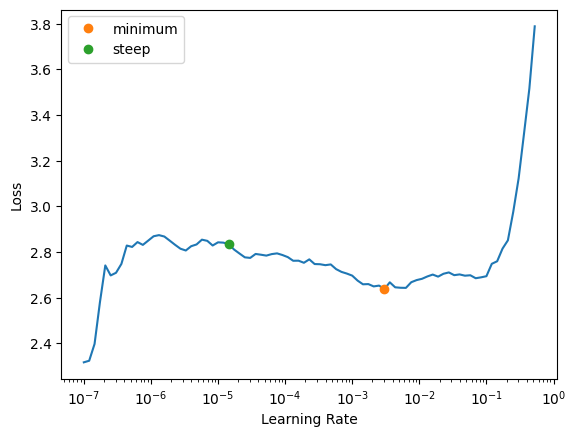

In [8]:
learn = vision_learner(dataloaders, resnet50, metrics=[accuracy, F1Score(average='macro')])

lr_min, lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))

In [9]:
learn.fine_tune(
    12, 
    base_lr=lr_min,
    freeze_epochs=3,
    cbs = [
        EarlyStoppingCallback(monitor='valid_loss', patience=2),
        ReduceLROnPlateau(monitor='valid_loss', patience=2),
    ]
)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,2.132393,1.563789,0.423523,0.362263,02:11
1,1.683241,1.330611,0.525316,0.424465,02:11
2,1.508681,1.249200,0.556435,0.424920,02:11


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,1.354425,1.125328,0.588608,0.461565,02:47
1,1.248868,1.088321,0.609441,0.473428,02:47
2,1.196795,1.029374,0.630802,0.501639,02:46
3,1.098504,0.940856,0.656382,0.538023,02:46
4,1.018728,0.878842,0.688291,0.551813,02:46
5,0.934994,0.828378,0.704378,0.575133,02:47
6,0.882804,0.814179,0.715454,0.603090,02:46
7,0.839495,0.775759,0.726530,0.607590,02:46
8,0.784656,0.757691,0.738397,0.618526,02:46
9,0.783615,0.752804,0.739715,0.621180,02:46


In [10]:
def get_ethnicity_probabilities(image):
    pred, pred_idx, probs = learn.predict(image)
    return {learn.dls.vocab[i]: p.item() for i, p in enumerate(probs)}

In [11]:
learn.export('./models/fastai_model_v3.pkl')

In [12]:
benchmark = learn.validate()
print(f'Validation Accuracy: {benchmark[1]:.4f}')

Validation Accuracy: 0.7447
